In [1]:
!git clone https://github.com/sakanaowo/PlantXViT

Cloning into 'PlantXViT'...
remote: Enumerating objects: 104802, done.
remote: Total 104802 (delta 0), reused 0 (delta 0), pack-reused 104802 (from 1)
Receiving objects: 100% (104802/104802), 2.45 GiB | 60.85 MiB/s, done.
Resolving deltas: 100% (30441/30441), done.
Updating files: 100% (104346/104346), done.


In [2]:
%cd PlantXViT

/content/PlantXViT


In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.0),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [4]:
root_dir='./data/raw/plantvillage'

In [7]:
train_dataset = datasets.ImageFolder(os.path.join(root_dir, "train"), transform=image_transforms)
val_dataset = datasets.ImageFolder(os.path.join(root_dir, "val"), transform=image_transforms)
test_dataset = datasets.ImageFolder(os.path.join(root_dir, "test"), transform=image_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import VGG16_Weights




# inception refine
class InceptionBlock(nn.Module):
    def __init__(self, in_channels=128):
        super(InceptionBlock, self).__init__()
        # Nhánh 1: 1x1
        self.branch1x1 = nn.Sequential(
            nn.Conv2d(in_channels, 128, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )

        # Nhánh 2: 1x1 -> 3x1 + 1x3
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, 96, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.Conv2d(96, 128, kernel_size=(3, 1), padding=(1, 0)),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=(1, 3), padding=(0, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )

        # Nhánh 3: 1x1 -> 3x1 + 1x3 -> 3x1 + 1x3
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 96, kernel_size=(3, 1), padding=(1, 0)),
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.Conv2d(96, 96, kernel_size=(1, 3), padding=(0, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.Conv2d(96, 192, kernel_size=(3, 1), padding=(1, 0)),
            nn.ReLU(),
            nn.BatchNorm2d(192),
            nn.Conv2d(192, 192, kernel_size=(1, 3), padding=(0, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(192)
        )

        # Nhánh 4: MaxPool -> 1x1
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, 64, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

    def forward(self, x):
        b1 = self.branch1x1(x)
        b2 = self.branch3x3(x)
        b3 = self.branch5x5(x)
        b4 = self.branch_pool(x)
        return torch.cat([b1, b2, b3, b4], dim=1)


class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, patch_size=5, emb_size=16):
        super().__init__()
        self.patch_size = patch_size
        self.emb_size = emb_size
        self.proj = nn.Linear(in_channels * patch_size * patch_size, emb_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.permute(0, 2, 3, 1, 4, 5).contiguous()
        x = x.view(B, -1, C * self.patch_size * self.patch_size)
        return self.proj(x)  # shape: (b,num patches,emb size)


# -------- Transformer Encoder Block (ViT block) --------
class TransformerBlock(nn.Module):
    def __init__(self, emb_size=16, dropout=0.3):
        super().__init__()
        self.norm1 = nn.LayerNorm(emb_size)
        self.attn = nn.MultiheadAttention(emb_size, num_heads=2, batch_first=True)
        self.norm2 = nn.LayerNorm(emb_size)
        self.mlp = nn.Sequential(
            nn.Linear(emb_size, emb_size * 2),
            nn.GELU(),
            nn.Linear(emb_size * 2, emb_size),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x_attn, _ = self.attn(self.norm1(x), self.norm1(x), self.norm1(x))
        x = x + x_attn
        x = x + self.mlp(self.norm2(x))
        return x


# -------- PlantXViT Model --------
class PlantXViT(nn.Module):
    def __init__(self, num_classes=4, patch_size=5, emb_size=16, num_blocks=4, dropout=0.1):
        super().__init__()

        # VGG16 (2 blocks)
        vgg = models.vgg16(weights=VGG16_Weights.DEFAULT)
        self.vgg_block = nn.Sequential(*list(vgg.features[:10]))
        # self.vgg_block = nn.Sequential(*vgg[:10])  # output: (B, 128, 56, 56)

        # Inception-like block → (B, 384, 56, 56)
        self.inception = InceptionBlock(in_channels=128)

        # Patch Embedding → (B, 121, 16)
        # self.patch_embed = PatchEmbedding(in_channels=384, patch_size=patch_size, emb_size=emb_size)
        self.patch_embed = PatchEmbedding(in_channels=512, patch_size=patch_size, emb_size=emb_size)

        # Transformer blocks
        self.transformer = nn.Sequential(*[TransformerBlock(emb_size, dropout) for _ in range(num_blocks)])

        # Classification head
        self.norm = nn.LayerNorm(emb_size)
        self.global_pool = nn.AdaptiveAvgPool1d(1)  # (B, emb_size, 1)
        self.classifier = nn.Linear(emb_size, num_classes)

    def forward(self, x):
        x = self.vgg_block(x)  # (B, 128, 56, 56)
        x = self.inception(x)  # (B, 384, 56, 56)
        x = self.patch_embed(x)  # (B, 121, 16)
        x = self.transformer(x)  # (B, 121, 16)
        x = self.norm(x)  # (B, 121, 16)
        x = x.permute(0, 2, 1)  # (B, 16, 121)
        x = self.global_pool(x).squeeze(-1)  # (B, 16)
        return self.classifier(x)  # (B, num_classes)


In [9]:
model = PlantXViT(num_classes=38)
criterion=nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 225MB/s]


In [10]:
DATA_DIR=root_dir
BATCH_SIZE=16
EPOCHS=50
LR=1e-4
NUM_CLASSES=38
DEVICE=torch.device('cuda')
MODEL_PATH = "./outputs/plantvillage/models/plantxvit_best.pth"

os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
from tqdm import tqdm

In [12]:

model.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

In [13]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for inputs, labels in tqdm(loader, desc="Training"):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc




In [14]:
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluating"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc


In [15]:
best_val_acc = 0
patience,wait=5,0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_PATH)
        print(f"✅ Saved best model to {MODEL_PATH}")
        wait=0
    else:
      wait+=1
      if wait>=patience:
        print(f"Early stopping at epoch {epoch+1}")
        break



Epoch 1/50


Evaluating: 100%|██████████| 510/510 [00:10<00:00, 46.69it/s]


Train Loss: 2.1269 | Acc: 0.5970
Val   Loss: 1.2831 | Acc: 0.7807
✅ Saved best model to ./outputs/plantvillage/models/plantxvit_best.pth

Epoch 2/50


Evaluating: 100%|██████████| 510/510 [00:10<00:00, 46.68it/s]


Train Loss: 0.9626 | Acc: 0.8216
Val   Loss: 0.6547 | Acc: 0.8764
✅ Saved best model to ./outputs/plantvillage/models/plantxvit_best.pth

Epoch 3/50


Evaluating: 100%|██████████| 510/510 [00:11<00:00, 46.32it/s]


Train Loss: 0.5063 | Acc: 0.9048
Val   Loss: 0.3614 | Acc: 0.9347
✅ Saved best model to ./outputs/plantvillage/models/plantxvit_best.pth

Epoch 4/50


Evaluating: 100%|██████████| 510/510 [00:10<00:00, 46.56it/s]


Train Loss: 0.2962 | Acc: 0.9468
Val   Loss: 0.2134 | Acc: 0.9558
✅ Saved best model to ./outputs/plantvillage/models/plantxvit_best.pth

Epoch 5/50


Evaluating: 100%|██████████| 510/510 [00:10<00:00, 46.80it/s]


Train Loss: 0.1901 | Acc: 0.9653
Val   Loss: 0.1790 | Acc: 0.9595
✅ Saved best model to ./outputs/plantvillage/models/plantxvit_best.pth

Epoch 6/50


Evaluating: 100%|██████████| 510/510 [00:11<00:00, 46.31it/s]


Train Loss: 0.1314 | Acc: 0.9739
Val   Loss: 0.1094 | Acc: 0.9756
✅ Saved best model to ./outputs/plantvillage/models/plantxvit_best.pth

Epoch 7/50


Evaluating: 100%|██████████| 510/510 [00:10<00:00, 46.72it/s]


Train Loss: 0.0988 | Acc: 0.9800
Val   Loss: 0.1419 | Acc: 0.9622

Epoch 8/50


Evaluating: 100%|██████████| 510/510 [00:10<00:00, 46.43it/s]


Train Loss: 0.0799 | Acc: 0.9836
Val   Loss: 0.0880 | Acc: 0.9766
✅ Saved best model to ./outputs/plantvillage/models/plantxvit_best.pth

Epoch 9/50


Evaluating: 100%|██████████| 510/510 [00:10<00:00, 46.51it/s]


Train Loss: 0.0670 | Acc: 0.9850
Val   Loss: 0.0814 | Acc: 0.9791
✅ Saved best model to ./outputs/plantvillage/models/plantxvit_best.pth

Epoch 10/50


Evaluating: 100%|██████████| 510/510 [00:11<00:00, 45.56it/s]


Train Loss: 0.0561 | Acc: 0.9870
Val   Loss: 0.0704 | Acc: 0.9804
✅ Saved best model to ./outputs/plantvillage/models/plantxvit_best.pth

Epoch 11/50


Evaluating: 100%|██████████| 510/510 [00:10<00:00, 46.91it/s]


Train Loss: 0.0486 | Acc: 0.9888
Val   Loss: 0.0746 | Acc: 0.9801

Epoch 12/50


Evaluating: 100%|██████████| 510/510 [00:11<00:00, 46.16it/s]


Train Loss: 0.0433 | Acc: 0.9900
Val   Loss: 0.0566 | Acc: 0.9833
✅ Saved best model to ./outputs/plantvillage/models/plantxvit_best.pth

Epoch 13/50


Evaluating: 100%|██████████| 510/510 [00:11<00:00, 46.00it/s]


Train Loss: 0.0426 | Acc: 0.9897
Val   Loss: 0.0488 | Acc: 0.9849
✅ Saved best model to ./outputs/plantvillage/models/plantxvit_best.pth

Epoch 14/50


Evaluating: 100%|██████████| 510/510 [00:10<00:00, 46.58it/s]


Train Loss: 0.0376 | Acc: 0.9910
Val   Loss: 0.0425 | Acc: 0.9877
✅ Saved best model to ./outputs/plantvillage/models/plantxvit_best.pth

Epoch 15/50


Evaluating: 100%|██████████| 510/510 [00:11<00:00, 46.34it/s]


Train Loss: 0.0345 | Acc: 0.9912
Val   Loss: 0.0569 | Acc: 0.9832

Epoch 16/50


Evaluating: 100%|██████████| 510/510 [00:10<00:00, 46.69it/s]


Train Loss: 0.0331 | Acc: 0.9917
Val   Loss: 0.0573 | Acc: 0.9837

Epoch 17/50


Evaluating: 100%|██████████| 510/510 [00:11<00:00, 45.93it/s]


Train Loss: 0.0297 | Acc: 0.9929
Val   Loss: 0.0684 | Acc: 0.9785

Epoch 18/50


Evaluating: 100%|██████████| 510/510 [00:11<00:00, 45.89it/s]


Train Loss: 0.0262 | Acc: 0.9938
Val   Loss: 0.0808 | Acc: 0.9753

Epoch 19/50


Evaluating: 100%|██████████| 510/510 [00:10<00:00, 46.66it/s]

Train Loss: 0.0269 | Acc: 0.9925
Val   Loss: 0.0805 | Acc: 0.9738
Early stopping at epoch 19


In [16]:
log_text="""
Epoch 1/50
Training: 100%|██████████| 2375/2375 [01:34<00:00, 25.20it/s]
Evaluating: 100%|██████████| 510/510 [00:10<00:00, 46.69it/s]
Train Loss: 2.1269 | Acc: 0.5970
Val   Loss: 1.2831 | Acc: 0.7807
✅ Saved best model to ./outputs/plantvillage/models/plantxvit_best.pth

Epoch 2/50
Training: 100%|██████████| 2375/2375 [01:31<00:00, 25.86it/s]
Evaluating: 100%|██████████| 510/510 [00:10<00:00, 46.68it/s]
Train Loss: 0.9626 | Acc: 0.8216
Val   Loss: 0.6547 | Acc: 0.8764
✅ Saved best model to ./outputs/plantvillage/models/plantxvit_best.pth

Epoch 3/50
Training: 100%|██████████| 2375/2375 [01:32<00:00, 25.79it/s]
Evaluating: 100%|██████████| 510/510 [00:11<00:00, 46.32it/s]
Train Loss: 0.5063 | Acc: 0.9048
Val   Loss: 0.3614 | Acc: 0.9347
✅ Saved best model to ./outputs/plantvillage/models/plantxvit_best.pth

Epoch 4/50
Training: 100%|██████████| 2375/2375 [01:32<00:00, 25.80it/s]
Evaluating: 100%|██████████| 510/510 [00:10<00:00, 46.56it/s]
Train Loss: 0.2962 | Acc: 0.9468
Val   Loss: 0.2134 | Acc: 0.9558
✅ Saved best model to ./outputs/plantvillage/models/plantxvit_best.pth

Epoch 5/50
Training: 100%|██████████| 2375/2375 [01:32<00:00, 25.78it/s]
Evaluating: 100%|██████████| 510/510 [00:10<00:00, 46.80it/s]
Train Loss: 0.1901 | Acc: 0.9653
Val   Loss: 0.1790 | Acc: 0.9595
✅ Saved best model to ./outputs/plantvillage/models/plantxvit_best.pth

Epoch 6/50
Training: 100%|██████████| 2375/2375 [01:32<00:00, 25.68it/s]
Evaluating: 100%|██████████| 510/510 [00:11<00:00, 46.31it/s]
Train Loss: 0.1314 | Acc: 0.9739
Val   Loss: 0.1094 | Acc: 0.9756
✅ Saved best model to ./outputs/plantvillage/models/plantxvit_best.pth

Epoch 7/50
Training: 100%|██████████| 2375/2375 [01:32<00:00, 25.70it/s]
Evaluating: 100%|██████████| 510/510 [00:10<00:00, 46.72it/s]
Train Loss: 0.0988 | Acc: 0.9800
Val   Loss: 0.1419 | Acc: 0.9622

Epoch 8/50
Training: 100%|██████████| 2375/2375 [01:31<00:00, 25.91it/s]
Evaluating: 100%|██████████| 510/510 [00:10<00:00, 46.43it/s]
Train Loss: 0.0799 | Acc: 0.9836
Val   Loss: 0.0880 | Acc: 0.9766
✅ Saved best model to ./outputs/plantvillage/models/plantxvit_best.pth

Epoch 9/50
Training: 100%|██████████| 2375/2375 [01:33<00:00, 25.47it/s]
Evaluating: 100%|██████████| 510/510 [00:10<00:00, 46.51it/s]
Train Loss: 0.0670 | Acc: 0.9850
Val   Loss: 0.0814 | Acc: 0.9791
✅ Saved best model to ./outputs/plantvillage/models/plantxvit_best.pth

Epoch 10/50
Training: 100%|██████████| 2375/2375 [01:32<00:00, 25.78it/s]
Evaluating: 100%|██████████| 510/510 [00:11<00:00, 45.56it/s]
Train Loss: 0.0561 | Acc: 0.9870
Val   Loss: 0.0704 | Acc: 0.9804
✅ Saved best model to ./outputs/plantvillage/models/plantxvit_best.pth

Epoch 11/50
Training: 100%|██████████| 2375/2375 [01:32<00:00, 25.72it/s]
Evaluating: 100%|██████████| 510/510 [00:10<00:00, 46.91it/s]
Train Loss: 0.0486 | Acc: 0.9888
Val   Loss: 0.0746 | Acc: 0.9801

Epoch 12/50
Training: 100%|██████████| 2375/2375 [01:32<00:00, 25.60it/s]
Evaluating: 100%|██████████| 510/510 [00:11<00:00, 46.16it/s]
Train Loss: 0.0433 | Acc: 0.9900
Val   Loss: 0.0566 | Acc: 0.9833
✅ Saved best model to ./outputs/plantvillage/models/plantxvit_best.pth

Epoch 13/50
Training: 100%|██████████| 2375/2375 [01:32<00:00, 25.55it/s]
Evaluating: 100%|██████████| 510/510 [00:11<00:00, 46.00it/s]
Train Loss: 0.0426 | Acc: 0.9897
Val   Loss: 0.0488 | Acc: 0.9849
✅ Saved best model to ./outputs/plantvillage/models/plantxvit_best.pth

Epoch 14/50
Training: 100%|██████████| 2375/2375 [01:32<00:00, 25.66it/s]
Evaluating: 100%|██████████| 510/510 [00:10<00:00, 46.58it/s]
Train Loss: 0.0376 | Acc: 0.9910
Val   Loss: 0.0425 | Acc: 0.9877
✅ Saved best model to ./outputs/plantvillage/models/plantxvit_best.pth

Epoch 15/50
Training: 100%|██████████| 2375/2375 [01:32<00:00, 25.63it/s]
Evaluating: 100%|██████████| 510/510 [00:11<00:00, 46.34it/s]
Train Loss: 0.0345 | Acc: 0.9912
Val   Loss: 0.0569 | Acc: 0.9832

Epoch 16/50
Training: 100%|██████████| 2375/2375 [01:32<00:00, 25.74it/s]
Evaluating: 100%|██████████| 510/510 [00:10<00:00, 46.69it/s]
Train Loss: 0.0331 | Acc: 0.9917
Val   Loss: 0.0573 | Acc: 0.9837

Epoch 17/50
Training: 100%|██████████| 2375/2375 [01:31<00:00, 25.84it/s]
Evaluating: 100%|██████████| 510/510 [00:11<00:00, 45.93it/s]
Train Loss: 0.0297 | Acc: 0.9929
Val   Loss: 0.0684 | Acc: 0.9785

Epoch 18/50
Training: 100%|██████████| 2375/2375 [01:32<00:00, 25.57it/s]
Evaluating: 100%|██████████| 510/510 [00:11<00:00, 45.89it/s]
Train Loss: 0.0262 | Acc: 0.9938
Val   Loss: 0.0808 | Acc: 0.9753

Epoch 19/50
Training: 100%|██████████| 2375/2375 [01:32<00:00, 25.56it/s]
Evaluating: 100%|██████████| 510/510 [00:10<00:00, 46.66it/s]Train Loss: 0.0269 | Acc: 0.9925
Val   Loss: 0.0805 | Acc: 0.9738
Early stopping at epoch 19
"""

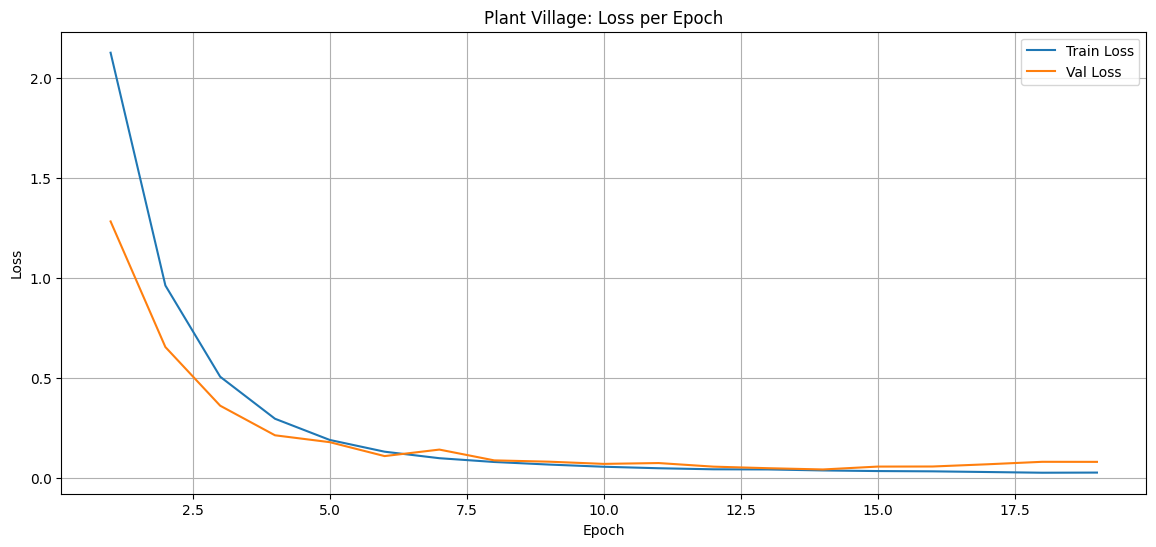

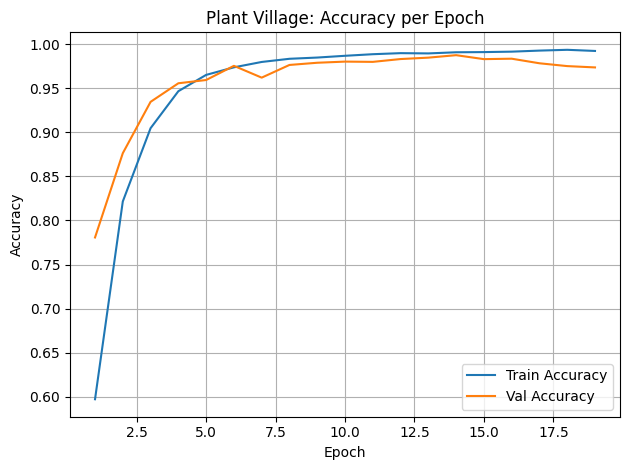

In [19]:
import re
train_lines = re.findall(r'Train Loss: ([\d\.]+) \| Acc: ([\d\.]+)', log_text)
val_lines = re.findall(r'Val\s+Loss: ([\d\.]+) \| Acc: ([\d\.]+)', log_text)

# Tách ra các list số
train_losses = [float(l[0]) for l in train_lines]
train_accuracies = [float(l[1]) for l in train_lines]
val_losses = [float(l[0]) for l in val_lines]
val_accuracies = [float(l[1]) for l in val_lines]

import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))

# Loss
# plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.title('Plant Village: Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy
# plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.title('Plant Village: Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
